# Pricing European Options Using the Black-Scholes-Merton Model

A **European option** is the right, but not the obligation, to buy or sell an underlying asset at a specified **strike price** on a **specified date**. $S_T$ be the price of the underlying asset at time $T$, where $T$ is the time interval between today and the specified date. Let $K$ be the strike price.

A **European put option** is the right, but not the obligation, to sell an underlying asset at a specified **strike price** on a **specified date**. In that case, the **payoff** of the option is $\max(K - S_T, 0)$.

A **European call option** is the right, but not the obligation, to buy an underlying asset at a specified **strike price** on a **specified date**. In that case, the **payoff** of the option is $\max(S_T - K, 0)$.

We assume here that the underlying asset is a share of a stock. Our goal is to price a European option given the stock, the strike price, and the time interval $T$ between the day the contract is made and the maturity date. 

Importing the relevant libraries:

In [1]:
!pip install pandas_datareader

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import yfinance as yf
import numpy as np
import numpy.random as npr
import math
import pandas as pd
import json
import pandas_datareader.data as web
import datetime as dt
from pylab import plt

We first calculate the **daily log returns** of the share: 

$$\frac{P_t}{P_{t-1}}$$ 

In [3]:
'''
Calculating the daily log returns of a stock.
ticker_symb: string representing a ticker symbol like "AAPL"
Returns an ndarray containing the daily log returns of the stock.
'''

def calc_daily_log_return(ticker_symb):
    ticker = yf.Ticker(ticker_symb)  # returns a Ticker object

    # The history() method of a Ticker object returns a Pandas DataFrame which is converted to an ndarray by the method to_numpy()
    close_history = ticker.history(period="max")["Close"].to_numpy()
    
    daily_log_return = np.log(close_history[1:]/close_history[:-1])

    return daily_log_return

**Black-Scholes-Merton setup for option pricing**: 

$$ S_T = S_0 \exp \left( \left( r - \frac{1}{2} \sigma^2 \right) T + \sigma \sqrt{T} z \right)$$

where:

$S_0$: level of stock index today

$S_T$: level of stock index at a future date T

$r$: constant riskless short rate

$\sigma$: constant volatility (= standard deviation of returns) of $S$

$z$: standard normally distributed random variable

The riskless short rate is approximated by Treasury-bill yields. We obtain them based on the time horizon. For instance, if the maturity is 3 months from now, we use the yield of the three-month T-bill. The BSM model assumes continuous compounding, and thus, if we obtain the yield as $r$ then the riskless rate $r_c$ is given by

$$ r_c = \ln(1 + r) $$

In [4]:
'''
This function takes t, the time interval between today and maturity, in days.
'''

def calc_r(t):
    start = dt.datetime(2026,1,1)  # start date, irrelevant here but required as an argument in the DataReader function
    end = dt.datetime.today()
    r = 0

    # 3 month horizon, use 3-month T-bill
    if t <= 75:
        r = web.DataReader("DTB3", "fred", start, end).iloc[-1,0] / 100 # rates are returned in percentage and so division by 100
    
    # 3 to 9 month horizon, use 6-month T-bill
    elif t <= 225:
        r = web.DataReader("DTB6", "fred", start, end).iloc[-1,0] / 100
    
    # for longer time horizons, use 1-year T-bill
    else:
        r = web.DataReader("DTB1YR", "fred", start, end).iloc[-1,0] / 100

    r_c = np.log(1 + r)  # this is the annual riskless rate

    return r_c    

Now, we compute `num_sim` possible prices after `t` days. 

For each $S_T$ we obtain, we calculate the option payoff as $\max(S_T - K, 0)$ if it is a call option and $\max(K- S_T, 0)$ if it is a put option. Then we take the expected value of the payoffs:

For a call option:
$$ \mathbb{E}^{\mathbb{Q}}[\max(S_T - K, 0)]$$

For a put option:
$$ \mathbb{E}^{\mathbb{Q}}[\max(K - S_T, 0)]$$

Lastly, we must discount the expected payoff to obtain the option price:

For a call option:
$$ e^{-rT} \mathbb{E}^{\mathbb{Q}}[\max(S_T - K, 0)]$$

For a put option:
$$ e^{-rT} \mathbb{E}^{\mathbb{Q}}[\max(K - S_T, 0)]$$

In [5]:
'''
t: time interval between today and maturity, in days
num_sim: number of simulations we want to perfom
K: strike price
call: boolean value, true if a call option, false if a put option
'''

def simulate(ticker_symb, t, num_sim, K, call):
    ticker = yf.Ticker(ticker_symb)
    close_history = ticker.history(period="max")["Close"].to_numpy()
    daily_ret = calc_daily_log_return(ticker_symb)
    
    r = calc_r(t)
    sigma = np.std(daily_ret, ddof=1) * np.sqrt(252)  # np.std(daily_ret) gives daily volatility, multiply by sqrt(252) to obtain annual volatility

    # Since r is annual, we divide t by 252 (no. of working days in a year)
    T = t / 252

    S0 = close_history[-1]
    Z = npr.randn(num_sim)
    
    S_T = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * Z)
    
    # call option
    if call:
        payoff = np.maximum(S_T - K, 0)

    # put option
    else:
        payoff = np.maximum(K - S_T, 0)
        
    # discounting
    price = np.exp(-r * T) * np.mean(payoff)
    
    return price, payoff

As an example, consider a European call option with maturity a year from now, and a strike price of 275, where the underlying is a share of Apple. We plot a histogram of the payoffs. 

Text(0.5, 0, 'payoff')

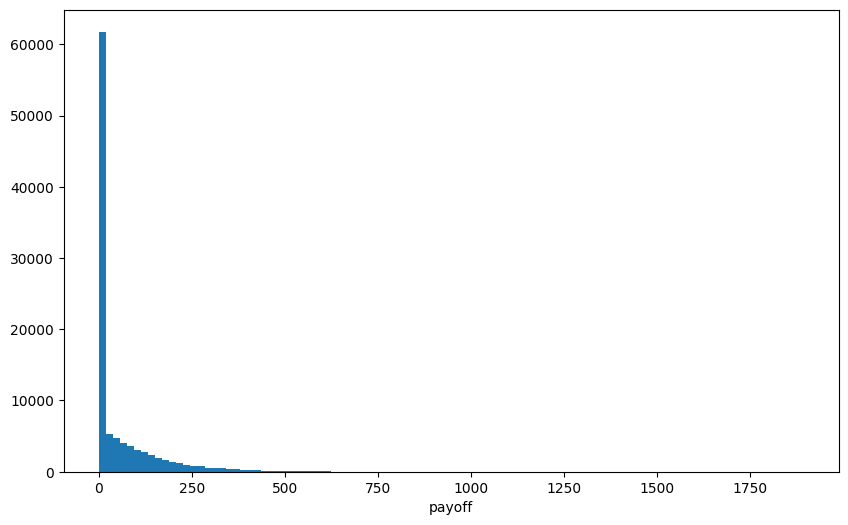

In [6]:
price, payoff = simulate('AAPL', 252, 100000, 275, True)

plt.figure(figsize=(10,6))
plt.hist(payoff, bins=100)
plt.xlabel('payoff')

Count the number of entries in `payoff` that are 0 as follows:

In [7]:
count = np.sum(payoff == 0)
print("The number of payoffs that are zero is: " + str(count))

The number of payoffs that are zero is: 56102


Out of 100,000 simulations, 56,125 give 0 payoff, hence the high frequency in the first bin. Now, suppose we use log scale on the y axis:

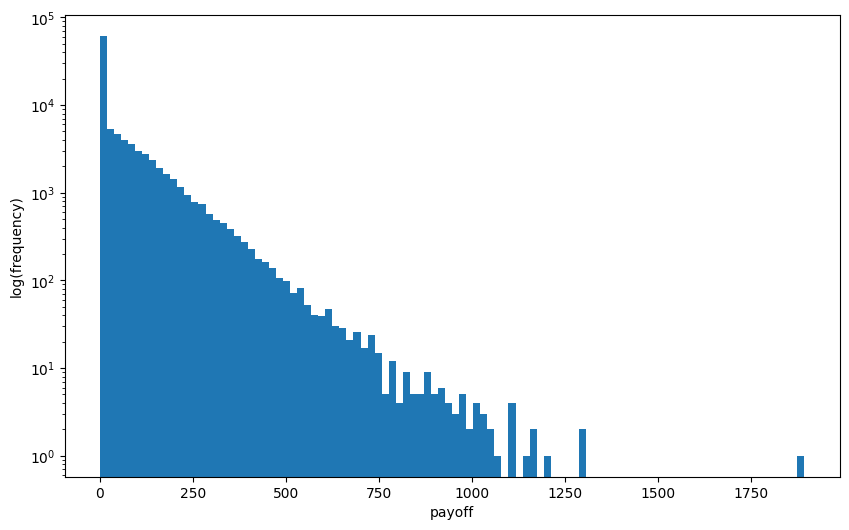

In [8]:
plt.figure(figsize=(10,6))
plt.hist(payoff, bins=100)
plt.xlabel('payoff')
plt.ylabel('log(frequency)')
plt.yscale('log')

To plot only the positive payoffs:

Text(0, 0.5, 'frequency')

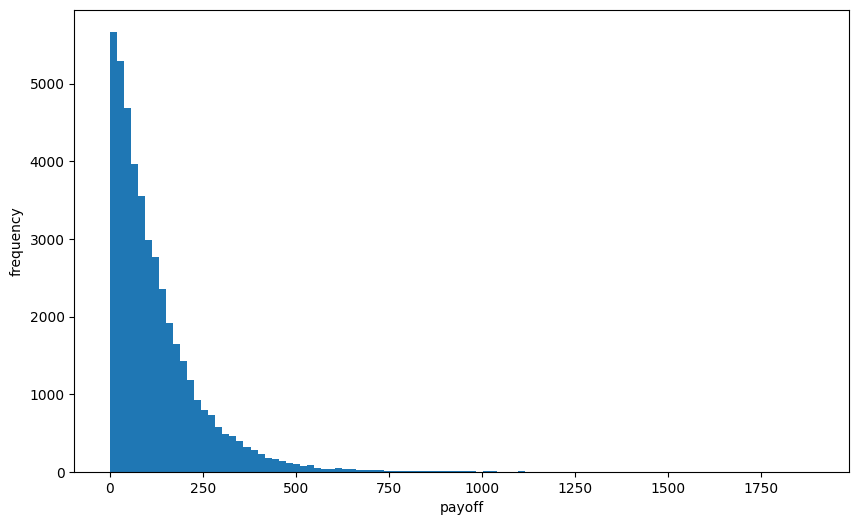

In [9]:
plt.figure(figsize=(10,6))
plt.hist(payoff[payoff > 0], bins=100)
plt.xlabel('payoff')
plt.ylabel('frequency')


Payoffs in a particular range:

Text(0, 0.5, 'frequency')

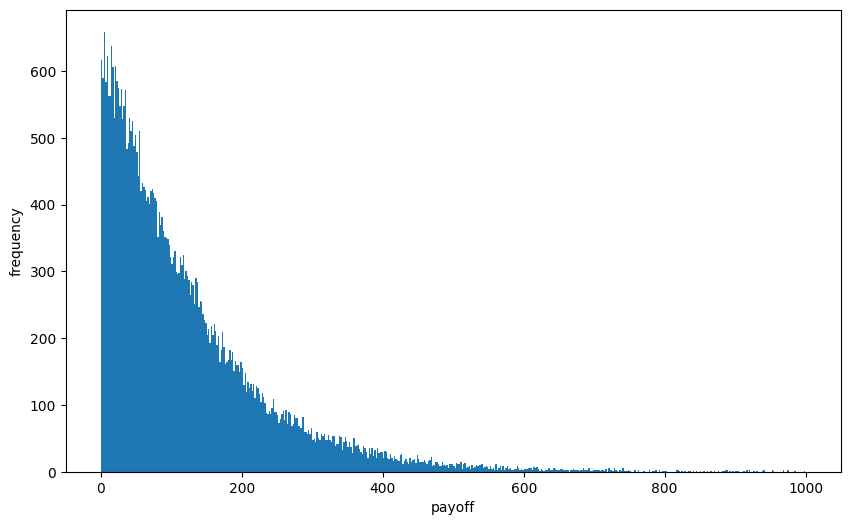

In [10]:
plt.figure(figsize=(10,6))
plt.hist(payoff[(payoff > 0) & (payoff < 1000)], bins=500)
plt.xlabel('payoff')
plt.ylabel('frequency')


The price of the option:

In [11]:
print("The price of the option is: " + str(price))

The price of the option is: 51.85348444696589
